# Install the dependency for data collection

In [1]:
!pip install yfinance ta

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 31.1 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=09762ac982030db311cb2af8b41f1e60b3e4ca1a87bec9131ed863e2e736dc81
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium=

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf

# Data Pre-processing

In [3]:
symbol = '2800.HK'#'AAPL'#'2800.HK'
stock = yf.Ticker(symbol)
df = stock.history(period="max")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

In [12]:
indicator_bollinger = BollingerBands(close=stock_data["Close"], window=20, window_dev=2)
macd = MACD(close=stock_data["Close"])
rsi = RSIIndicator(close=stock_data["Close"])
ichi = IchimokuIndicator(high=stock_data["High"],low=stock_data["Low"])

#get the technical indicators
stock_data['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
stock_data['bollinger_hband'] = indicator_bollinger.bollinger_hband()
stock_data['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
stock_data['macd'] = macd.macd()
stock_data['rsi'] = rsi.rsi()
stock_data['ichi_a'] = ichi.ichimoku_a()
stock_data['ichi_b'] = ichi.ichimoku_b()
stock_data['ichi_base'] = ichi.ichimoku_base_line()
stock_data['ichi_conv'] = ichi.ichimoku_conversion_line()
stock_data = stock_data.fillna(0)
stock_orig = stock_data

#stock = stock[250:]
stock_data

,Open,High,Low,Close,Volume,macd,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichi_a,ichi_b,ichi_base,ichi_conv
Date,,,,,,,,,,,,,,
2008-01-02,0.827761,0.729317,0.749538,0.742674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.739427,0.000000,0.000000
2008-01-03,0.807761,0.699191,0.718577,0.711996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723947,0.000000,0.000000
2008-01-04,0.826567,0.727518,0.747689,0.740843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723947,0.000000,0.000000
2008-01-07,0.816418,0.712230,0.731978,0.725275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723947,0.000000,0.000000
2008-01-08,0.814328,0.709083,0.728743,0.722070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723947,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,0.751045,0.613759,0.614140,0.619506,0.422646,0.009460,60.750844,0.593452,0.629813,0.557091,0.578136,0.568201,0.569125,0.587147
2022-02-11,0.745075,0.611061,0.617837,0.618590,0.410802,0.010505,60.386143,0.596108,0.631658,0.560559,0.578136,0.568201,0.569125,0.587147
2022-02-14,0.740896,0.601169,0.605823,0.603022,0.300364,0.009962,54.406696,0.596520,0.632189,0.560851,0.578136,0.568201,0.569125,0.587147


# Min-Max Normalization

In [6]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Feature: 0, Score: -0.00757
Feature: 1, Score: 0.51129
Feature: 2, Score: 0.48274
Feature: 3, Score: -0.00022
Feature: 4, Score: -0.07132
Feature: 5, Score: 0.00022
Feature: 6, Score: 0.00210
Feature: 7, Score: -0.00588
Feature: 8, Score: 0.01007
Feature: 9, Score: -0.03896
Feature: 10, Score: 0.02017
Feature: 11, Score: 0.02702
Feature: 12, Score: 0.00101


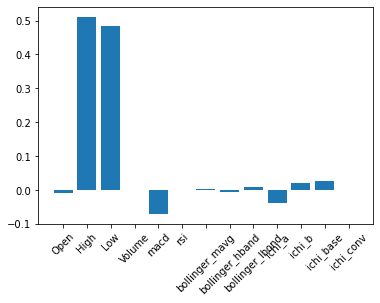

In [16]:
L_stock = stock_data.drop(['Close'],1)
model = LinearRegression()
model.fit(L_stock.iloc[:,:], stock_data.iloc[:,3])
importance = model.coef_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([L_stock.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=45)
plt.show()


In [9]:
#stock_final = stock.drop(['Open','Volume','macd','bb_bbm','bb_bbh','bb_bbl','ichi_a','ichi_conv'],1)
stock_final = stock_data.drop(['Open','High','macd','Low','ichi_b','rsi'],1)

features = 8 #6

window_size = 60
week = 7
X = []
Y = []
print(stock_final)
for i in range(0 , len(stock_data) - window_size , 1):
  X.append(np.array(stock_final.iloc[i:i+window_size,:]).reshape(window_size * features,1))
  Y.append(np.array(stock_data.iloc[i+window_size,3]).reshape(1,1))

train_X,test_X,train_label,test_label = train_test_split(X, Y, test_size=0.1,shuffle=False)
len_t = len(train_X)
# train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2,shuffle=True)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_label = np.array(train_label)
test_label = np.array(test_label)
# valid_label = np.array(valid_label)
# valid_X = np.array(valid_X)
train_X = train_X.reshape(train_X.shape[0],features,window_size,1)
test_X = test_X.reshape(test_X.shape[0],features,window_size,1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


               Close    Volume  bollinger_mavg  ...    ichi_a  ichi_base  ichi_conv
Date                                            ...                                
2008-01-02  0.742674  0.000000        0.000000  ...  0.000000   0.000000   0.000000
2008-01-03  0.711996  0.000000        0.000000  ...  0.000000   0.000000   0.000000
2008-01-04  0.740843  0.000000        0.000000  ...  0.000000   0.000000   0.000000
2008-01-07  0.725275  0.000000        0.000000  ...  0.000000   0.000000   0.000000
2008-01-08  0.722070  0.000000        0.000000  ...  0.000000   0.000000   0.000000
...              ...       ...             ...  ...       ...        ...        ...
2022-02-10  0.619506  0.422646        0.755569  ...  0.745630   0.747975   0.736604
2022-02-11  0.618590  0.410802        0.757360  ...  0.745630   0.747975   0.736604
2022-02-14  0.603022  0.300364        0.757638  ...  0.745630   0.747975   0.736604
2022-02-15  0.592949  0.247935        0.757484  ...  0.748402   0.747975   0

# Model Training

In [13]:
model = Sequential()
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,50,1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_label, validation_data=(test_X,test_label), epochs=200)
print(model.summary())
print(model.evaluate(test_X,test_label))

Epoch 1/200
97/97 [==============================] - 28s 70ms/step - loss: 0.0170 - val_loss: 0.0043
Epoch 2/200
97/97 [==============================] - 5s 47ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 3/200
97/97 [==============================] - 5s 47ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 4/200
97/97 [==============================] - 4s 46ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 5/200
97/97 [==============================] - 4s 46ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 6/200
97/97 [==============================] - 4s 45ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/200
97/97 [==============================] - 4s 45ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 8/200
97/97 [==============================] - 4s 45ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 9/200
97/97 [==============================] - 4s 45ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/200
97/97 [==============================] - 4s 45ms/step - loss: 0.0026 - val_loss: 0.001

# Model Evaluation

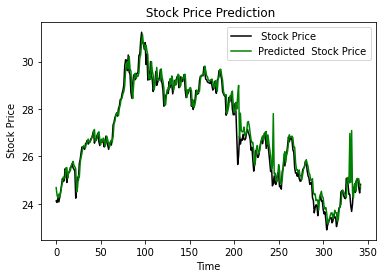

In [14]:
predicted  = model.predict(test_X)
test_label[:,0] = y_scaler.inverse_transform(test_label[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler.inverse_transform(predicted)
plt.plot(test_label[:,0], color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Make the price prediction for next day

In [15]:
x_pred = []
x_pred.append(np.array(stock_final.iloc[-window_size:,:]).reshape(window_size * features,1))
x_pred = np.array(x_pred)
x_pred = x_pred.reshape(x_pred.shape[0],features,window_size,1)
next_price  = model.predict(x_pred)
next_price = np.array(next_price[:,0]).reshape(-1,1)
next_price = y_scaler.inverse_transform(next_price)
next_price[0][0]

24.95679

# Save the Model

In [ ]:
#model.save('lstm-cnn.h5')